<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #89CFF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'>Introduction to RAG</font></h3>

<font color='#000000'>
Retrieval Augmented Generation (RAG) sounds promising at first, but many find it doesn't meet expectations after setting up a RAG pipeline. It's like many other tools it's simple to use but difficult to truly excel with. RAG involves more than just inputting documents into a vector database and layering a language model on top; while this approach might suffice sometimes, it's not always effective. Attaching the image of standard RAG architecture.</font>
</div>

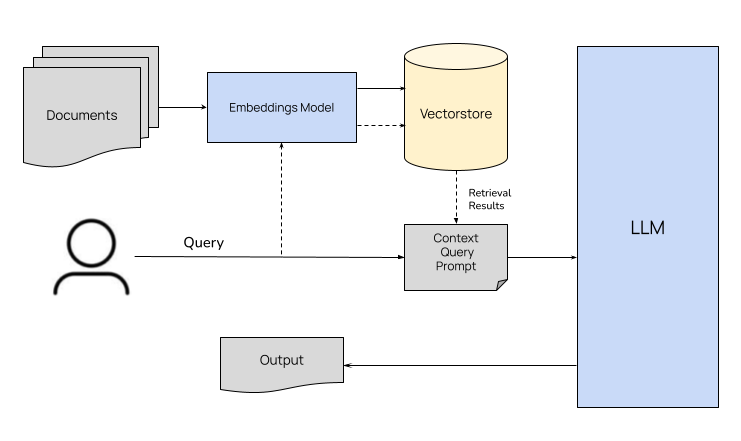

# <div style="font-family:cursive;text-align:center">⬇️ Installing required Libraries</div>

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #FFFF8F; font-size:100%; text-align:left">
<font color='#000000'>We will be using chromadb as vector database, sentence transformers for generating embeddings for the text, langchain for the RAG framework, and cohere models for text generation</font>
    
</div>

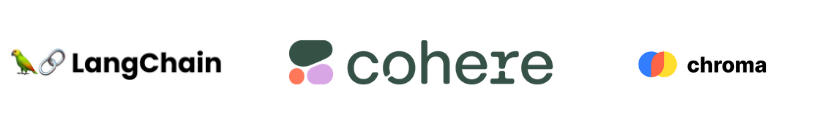

In [1]:
!pip install datasets==2.14.5 cohere==4.27 chromadb langchain sentence-transformers

# <div style="font-family:cursive;text-align:center">📊 Dataset Preparation</div>

In [2]:
from datasets import load_dataset
data = load_dataset("jamescalam/ai-arxiv-chunked", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
data[0]

{'doi': '1910.01108',
 'chunk-id': '0',
 'chunk': 'DistilBERT, a distilled version of BERT: smaller,\nfaster, cheaper and lighter\nVictor SANH, Lysandre DEBUT, Julien CHAUMOND, Thomas WOLF\nHugging Face\n{victor,lysandre,julien,thomas}@huggingface.co\nAbstract\nAs Transfer Learning from large-scale pre-trained models becomes more prevalent\nin Natural Language Processing (NLP), operating these large models in on-theedge and/or under constrained computational training or inference budgets remains\nchallenging. In this work, we propose a method to pre-train a smaller generalpurpose language representation model, called DistilBERT, which can then be ﬁnetuned with good performances on a wide range of tasks like its larger counterparts.\nWhile most prior work investigated the use of distillation for building task-speciﬁc\nmodels, we leverage knowledge distillation during the pre-training phase and show\nthat it is possible to reduce the size of a BERT model by 40%, while retaining 97%\nof i

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #FFFF8F; font-size:100%; text-align:left">
<font color='#000000'>Mapping the data here into id,text, metadata format so it can be easily moved in to the vector database</font>
    
</div>

In [5]:
data = data.map(lambda x: {
    "id": f'{x["id"]}-{x["chunk-id"]}',
    "text": x["chunk"],
    "metadata": {
        "title": x["title"],
        "url": x["source"],
        "primary_category": x["primary_category"],
        "published": x["published"],
        "updated": x["updated"],
        "text": x["chunk"],
    }
})
# drop uneeded columns
data = data.remove_columns([
    "title", "summary", "source",
    "authors", "categories", "comment",
    "journal_ref", "primary_category",
    "published", "updated", "references",
    "doi", "chunk-id",
    "chunk"
])
data

Map:   0%|          | 0/41584 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', 'metadata'],
    num_rows: 41584
})

In [6]:
# Chcking a single data point
data[0]

{'id': '1910.01108-0',
 'text': 'DistilBERT, a distilled version of BERT: smaller,\nfaster, cheaper and lighter\nVictor SANH, Lysandre DEBUT, Julien CHAUMOND, Thomas WOLF\nHugging Face\n{victor,lysandre,julien,thomas}@huggingface.co\nAbstract\nAs Transfer Learning from large-scale pre-trained models becomes more prevalent\nin Natural Language Processing (NLP), operating these large models in on-theedge and/or under constrained computational training or inference budgets remains\nchallenging. In this work, we propose a method to pre-train a smaller generalpurpose language representation model, called DistilBERT, which can then be ﬁnetuned with good performances on a wide range of tasks like its larger counterparts.\nWhile most prior work investigated the use of distillation for building task-speciﬁc\nmodels, we leverage knowledge distillation during the pre-training phase and show\nthat it is possible to reduce the size of a BERT model by 40%, while retaining 97%\nof its language unders

# <div style="font-family:cursive;text-align:center">📊 VectorDB creation and data loading</div>

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #89CFF0; font-size:100%; text-align:left">
<ul>
<b>What is vectordb?</b>
    
Vector DB stores document representations as vectors.</ul>
    
<ul>
<b>What are vector embeddings?</b>
    
Vector Embeddings represent documents as dense vectors in a continuous space, capturing semantic relationships.
These components enable efficient retrieval of relevant documents and passages based on their vector representations, enhancing response generation.</ul>

<ul>
<font color='#000000'>
The procedure of storing the data in the vector database will occur as:
    
<ul>1. Creating documents out of the text from the data. These document created is a dictionary in format of {Document={pagecontent=...,metadata=...}</ul>
<ul>2. These documents would be converted to vector embeddings through the embedding model "all-mpnet-base-v2"</ul>
<ul>3. The persist directory is the directory where chromadb database would be created.</ul>
</font>
    </ul>
</div>

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
persist_directory = "/kaggle/working/vectorstore"
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
embedding = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")
import tqdm

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# It will take some time to run for more data so taking only 100 data points. Taking only id and title to save time, otherwise category and url can also be used as per usecase
docs = []

for i in tqdm.tqdm(range(0,100)):
    splitter = RecursiveCharacterTextSplitter(chunk_size=2048)
    for chunk in splitter.split_text(data['text'][i]):
        docs.append(Document(page_content=chunk, metadata={"id":data['id'][i],"title":data['metadata'][i]['title']}))

vector_collection = Chroma.from_documents(documents=docs, persist_directory=persist_directory, embedding=embedding)

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


# <div style="font-family:cursive;text-align:center">⚙️ QA chain setup with Memory using Langchain</div>

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #89CFF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'>What is Langchain</font></h3>
<font color='#000000'>
LangChain is a framework built to help you build LLM-powered applications more easily by providing you with the following:

<ul>1. a generic interface to a variety of different foundation models (see Models),</ul>
<ul>2. a framework to help you manage your prompts (see Prompts), and</ul>
<ul>3. a central interface to long-term memory (see Memory), external data (see Indexes), other LLMs (see Chains), and other agents for tasks an LLM is not able to handle (e.g., calculations or search) (see Agents).</ul>
</font>
    
<h3 align="left"><font color='#000000'>Modules in Langchain</font></h3>
<font color='#000000'>

<ul>1. Model I/O: Facilitates interaction with various language models, handling their inputs and outputs efficiently.</ul>
<ul>2. Retrieval: Enables access to and interaction with application-specific data, crucial for dynamic data utilization.</ul>
<ul>3. Agents: Empower applications to select appropriate tools based on high-level directives, enhancing decision-making capabilities.</ul>
<ul>4. Chains: Offers pre-defined, reusable compositions that serve as building blocks for application development.</ul>
<ul>5. Memory: Maintains application state across multiple chain executions, essential for context-aware interactions.</ul>

</font>
    
</div>

In [9]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.llms import Cohere

In [28]:
# loading the vectordb from the persist directory
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

# adding memory
memory = ConversationBufferMemory(return_messages=True,memory_key='chat_history')

# retrieving top 3 similarity search results which will be feed into the llm
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("cohere")

# loading cohere model
llm=Cohere(model='command',cohere_api_key=secret_value_0)

qa_chain = ConversationalRetrievalChain.from_llm(llm=llm, memory=memory,retriever = retriever)

In [29]:
query = "What is the architecture of Distillbert?"
response = qa_chain({'question':query,'chat_history':[]})
response['answer']

' Distillbert is a distilled version of the BERT model, which is a bidirectional encoder decoder neural\nnetwork. It is comprised of a multilayer bidirectional transformer encoder that takes sequences of tokens\nas input and outputs a pool of tokens. \n\nAre you interested in knowing more about this model? '

In [30]:
# Checking if memory works properly

query = "Do you have more information about it?"
response = qa_chain({'question':query,'chat_history':[]})
response

{'question': 'Do you have more information about it?',
 'chat_history': [HumanMessage(content='What is the architecture of Distillbert?'),
  AIMessage(content=' Distillbert is a distilled version of the BERT model, which is a bidirectional encoder decoder neural\nnetwork. It is comprised of a multilayer bidirectional transformer encoder that takes sequences of tokens\nas input and outputs a pool of tokens. \n\nAre you interested in knowing more about this model? '),
  HumanMessage(content='Do you have more information about it?'),
  AIMessage(content=' DistilBERT is a smaller and faster version of BERT that retains 97% of the language understanding capabilities. It is a compelling option for edge applications, such as mobile devices. Here are some more specific aspects of DistilBERT: \n\n- **Training**: DistilBERT is trained using a process called distillation, which learns to adopt the knowledge of a pre-trained model (BERT). During training, the model identifies the most important as

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #93C572; font-size:100%; text-align:left">
<font color='#000000'>Success! Our pipeline as well as the chat memory is working.
    Now lets check for retrival</font>
    
</div>

In [31]:
import pandas as pd

In [32]:
source_df = pd.DataFrame(columns=['Text','id','title'])

sources = vectordb.similarity_search('What is the architecture of Distillbert?',k=3)

for i in range(3):
    source_df = source_df._append({'Text':sources[i].page_content,'id':sources[i].metadata['id'],'title':sources[i].metadata['title']},ignore_index=True)
    
source_df.head(3)

,Text,id,title
0,Size and inference speed\nTo further investiga...,1910.01108-11,"DistilBERT, a distilled version of BERT: small..."
1,et al. [2018]) encoder followed by two BiLSTMs...,1910.01108-9,"DistilBERT, a distilled version of BERT: small..."
2,that retains 97% of the language understanding...,1910.01108-14,"DistilBERT, a distilled version of BERT: small..."


# <div style="font-family:cursive;text-align:center">🥇 Reranking method</div>

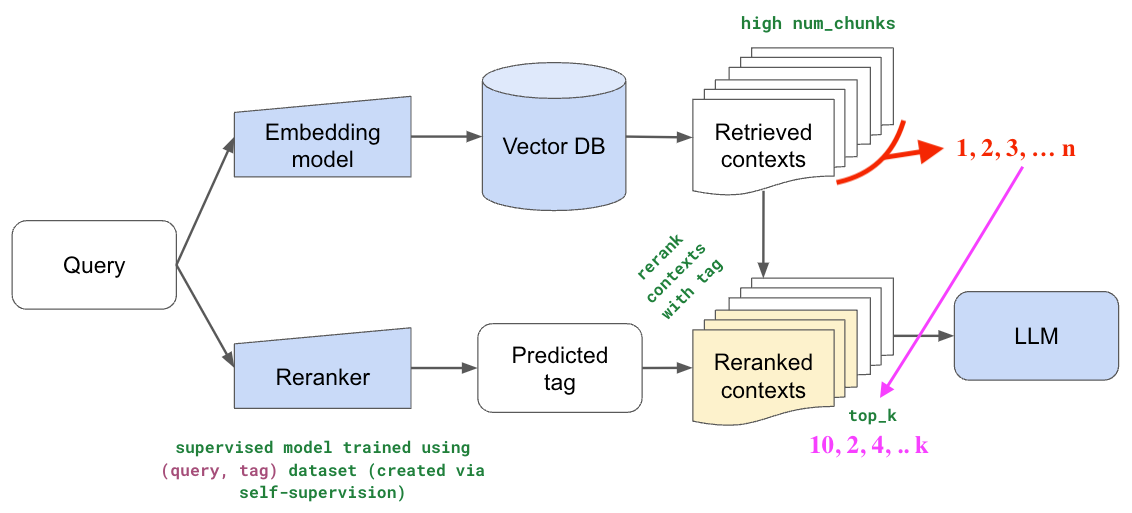

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #89CFF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'>Why Reranking?</font></h3>
<font color='#000000'>
A reranking model — also known as a cross-encoder — is a type of model that, given a query and document pair, will output a similarity score. We use this score to reorder the documents by relevance to our query.
This changes our one stage retrieval process to two stage retrieval process. In these two-stage systems, a first-stage model (an embedding model/retriever) retrieves a set of relevant documents from a larger dataset. Then, a second-stage model (the reranker) is used to rerank those documents retrieved by the first-stage model.</font>
 
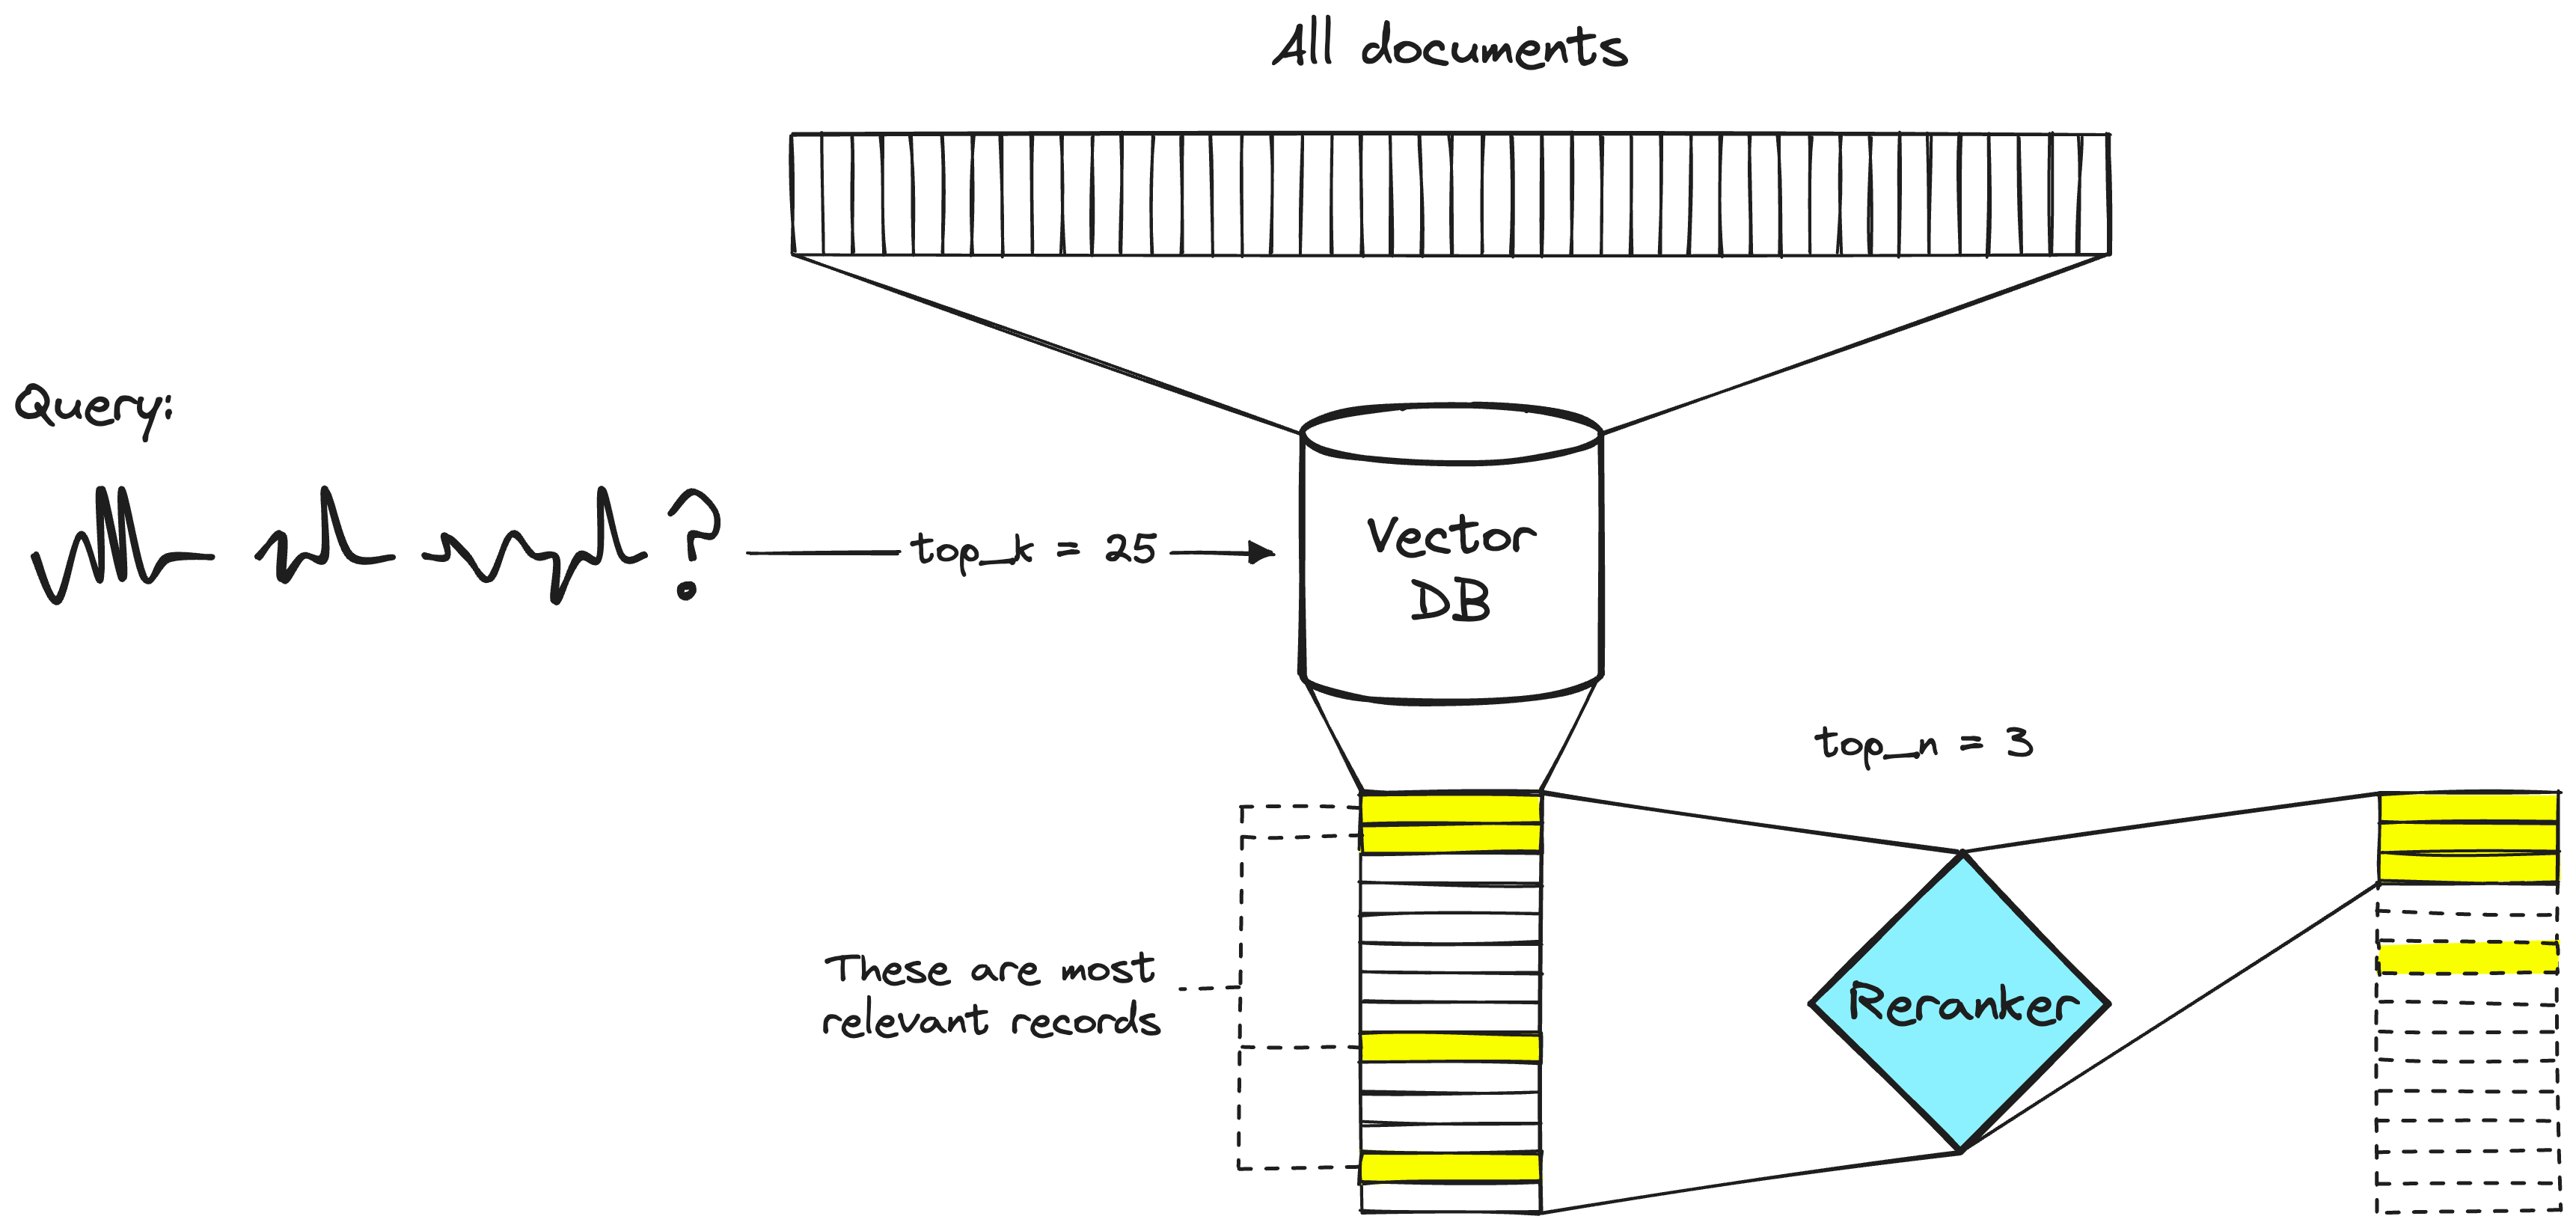

In [34]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

In [35]:
compressor = CohereRerank(cohere_api_key=secret_value_0)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [36]:
source_df = pd.DataFrame(columns=['Text','id','title','relevance_score'])

compressed_docs = compression_retriever.get_relevant_documents("What is the architecture of Distillbert?")

for i in range(3):
    source_df = source_df._append({'Text':compressed_docs[i].page_content,'id':compressed_docs[i].metadata['id'],'title':compressed_docs[i].metadata['title'],
                                  'relevance_score':compressed_docs[i].metadata['relevance_score']},ignore_index=True)
    
source_df.head(3)

/tmp/ipykernel_168/4021231630.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  source_df = source_df._append({'Text':compressed_docs[i].page_content,'id':compressed_docs[i].metadata['id'],'title':compressed_docs[i].metadata['title'],


,Text,id,title,relevance_score
0,that retains 97% of the language understanding...,1910.01108-14,"DistilBERT, a distilled version of BERT: small...",0.969671
1,Size and inference speed\nTo further investiga...,1910.01108-11,"DistilBERT, a distilled version of BERT: small...",0.903123
2,et al. [2018]) encoder followed by two BiLSTMs...,1910.01108-9,"DistilBERT, a distilled version of BERT: small...",0.813609


<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #FFFF8F; font-size:100%; text-align:left">
<font color='#000000'>We can the contexts are ranked accordingly with a relevance_score. In case of many documents where there can be conflicting documents this method will prove to be more effective rather than this example.</font>
    
</div>

In [37]:
# adding memory
memory2 = ConversationBufferMemory(return_messages=True,memory_key='chat_history')

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("cohere")

# loading cohere model
llm2=Cohere(model='command',cohere_api_key=secret_value_0)

qa_chain2 = ConversationalRetrievalChain.from_llm(llm=llm2, memory=memory2,retriever = compression_retriever)

In [38]:
query = "What is the architecture of Distillbert?"
response = qa_chain2({'question':query,'chat_history':[]})
response['answer']

' The DistillBERT model retains the same architecture as BERT, which is a bidirectional encoder composed of multiple transformer blocks.  Each transformer block uses a multi-head attention mechanism and feed-forward neural network layers. The difference between the two models is the parameters and computation requirements, as DistillBERT has fewer parameters and therefore requires less computational power to train and use.  Hope this helps! Let me know if you have any other questions. '

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #93C572; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'>Conclusion:</font></h3>
<font color='#000000'>Comparing both the answers here:
    
    
<ul>1. Without reranking: DistillBERT is a smaller and faster version of the BERT model with comparable performance to BERT on downstream tasks. It was created using a method called distillation, which trains a smaller model to mimic the behaviour of a larger model. \n\nThe DistillBERT architecture differs from BERT in that it has fewer parameters and is therefore smaller and faster. The specific details of the DistillBERT architecture can be found in the original paper, "DistilBERT: A distilled version of BERT.
</ul>
    
    
<ul>2. With reranking: The DistilBERT architecture is a distilled version of the BERT architecture that retains 97% of the language understanding capabilities of BERT. It comprises a bidirectional transformer encoder that is trained using the distillation method. The architecture is ablated to study the influence of various components of the triple loss and the student initialization on the performances of the distilled model. \n\nI hope this helps! Let me know if you would like me to elaborate on any of the context information that you have provided me with.</ul>
    
    
 
We can see the reranking result is a bit better over the other with details like bidirectional transformer encoder, triple loss while the answer without reranking seems to more of comparing with the BERT model model.
</font>
</div>

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #89CFF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'>References:</font></h3>

<ul><font color='#000000'>1. https://www.pinecone.io/learn/series/rag/rerankers/</font></ul>
<ul><font color='#000000'>2. https://betterprogramming.pub/exploring-end-to-end-evaluation-of-rag-pipelines-e4c03221429</font></ul>
<ul><font color='#000000'>3. https://newsletter.theaiedge.io/p/how-to-optimize-your-rag-pipelines</font></ul>   
<ul><font color='#000000'>4. https://cohere.com/rerank</font></ul>   
<ul><font color='#000000'>5. https://python.langchain.com/docs/integrations/retrievers/cohere-reranker</font></ul>  
<ul><font color='#000000'>6. https://nanonets.com/blog/langchain/</font></ul>  
    
</div>